In [1]:
import anndata as ad
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, Delaunay
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.multitest import multipletests
import sys
from tqdm import tqdm
sys.path.append("../src")
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from border_effects_kNN_del import sample_points_on_square, trunc_graphs
from plotting import add_sig_bar

In [3]:
np.random.seed(41)

In [4]:
ps = dict()
corrected_ps = dict()
new_edges = dict()
Ns = [100, 1000, 10000]
for N in Ns:
    ps[N] = list()
    corrected_ps[N] = list()
    new_edges[N] = list()
    
    for _ in tqdm(range(1000)):
        rand_coords = sample_points_on_square(N, 1, 1)
        out = trunc_graphs(coords=rand_coords, return_graphs=False, method="delaunay", xlim=0.5, ylim=0.5)
        edge_df = out["edge_df"]

        old = edge_df.loc[~edge_df["New edge"], "Edge length"]
        new = edge_df.loc[edge_df["New edge"], "Edge length"]
        new_edges[N].append(len(new) / (len(new) + len(old)))
        p_mwu_rand = mannwhitneyu(
            old,
            new,
            alternative="two-sided"
        ).pvalue
        
        ps[N].append(p_mwu_rand)
    _, corrected_ps[N], _, _ = multipletests(ps[N], alpha=0.05, method="fdr_bh")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.42it/s]


In [5]:
coords = sample_points_on_square(500, 1, 1)
out = trunc_graphs(coords=coords, return_graphs=True, method="delaunay", xlim=0.5, ylim=0.5)

coords = out["coords"]
subset = out["subset"]

G = out["G"]
subG = out["subG"]
plotG = out["plotG"]
truncG = out["truncG"]

edge_df = out["edge_df"]

In [6]:
edge_df["New edge"].value_counts()

New edge
False    289
True      30
Name: count, dtype: int64

In [7]:
p = mannwhitneyu(
    edge_df.loc[~edge_df["New edge"], "Edge length"],
    edge_df.loc[edge_df["New edge"], "Edge length"],
    alternative="two-sided"
).pvalue

In [8]:
len(truncG.edges)

319

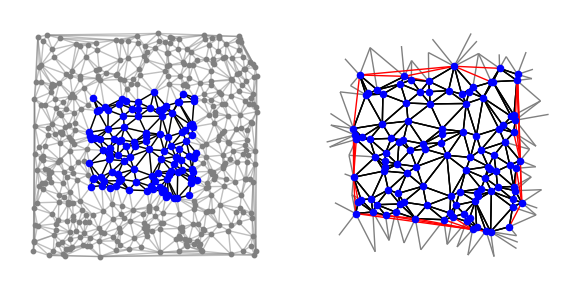

In [9]:
f, axs = plt.subplots(1, 2, figsize=(6, 3))

nx.draw(G, pos=coords, edge_color=(0.5, 0.5, 0.5, 0.5), node_size=10, node_color="gray", ax=axs[0])
nx.draw(subG, node_size=20, pos=coords, node_color="blue", ax=axs[0])

nx.draw_networkx_edges(plotG, pos=coords, ax=axs[1], edge_color="gray")
nx.draw(subG, node_size=20, pos=coords, ax=axs[1], node_color="blue")

edge_colors = [edge in G.edges for edge in truncG.edges]
nx.draw_networkx_edges(truncG, pos=coords, ax=axs[1], edge_color=np.where(edge_colors, "black", "red")) #, node_color=subcoords[:, 2], cmap="magma", vmin=-1, vmax=1)

for ax in axs:
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("../result_plots/fig2/delaunay_trunc_1.svg")

In [10]:
perc = pd.melt(pd.DataFrame(new_edges), var_name="N")
perc.loc[:, "value"] *= 100
lengths = pd.melt(pd.DataFrame(corrected_ps), var_name="N")
lengths.loc[:, "value"] = np.log10(lengths.loc[:, "value"])

289 30 3.2990246047220067e-15


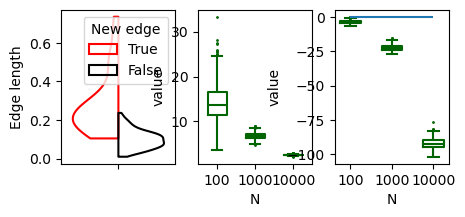

In [11]:
f, axs = plt.subplots(1, 3, figsize=(5, 2))

sns.violinplot(edge_df, y="Edge length", hue="New edge", cut=0, fill=False, split=True, palette={False: "black", True: "red"}, ax=axs[0], hue_order=[True, False], inner=None)

sns.boxplot(perc, x="N", y="value", ax=axs[1], color="darkgreen", fill=False, width=0.5, fliersize=1)
sns.boxplot(lengths, x="N", y="value", ax=axs[2], color="darkgreen", fill=False, width=0.5, fliersize=1)
axs[2].hlines(0.001, xmin=0, xmax=2)
ori = edge_df["New edge"].value_counts()[False]
new = len(edge_df) - ori
plt.savefig("../result_plots/fig2/delaunay_trunc_2.svg")
print(ori, new, p)

In [18]:
perc[perc["N"] == 10000].median()

N        10000.000000
value        2.553163
dtype: float64

In [29]:
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.001)))

981
936
783


In [30]:
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.001)))

1000
1000
1000


In [31]:
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.001)))

1000
1000
1000
